# **Lesson 07**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
import statsmodels.api as sm
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec

In [2]:
# plot parameters
import sys
sys.path.append('./../Libraries/')
import plt_params
%matplotlib inline

# Exercise 07.1
In the NSL simulator code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

## Solution

The approximation of cut-off radius can lead to wrong results, because the Lennard Jones potential describes a long range interaction. To improve this approximation one can consider the so called **tail corrections**, computed using the **radial distribution function** $g(r)$. In reduced units, these corrections assume the following form:

$$\frac{\langle V_{LJ}^* \rangle _{tail}}{N} = 8 \pi \rho^* \left[ \frac{1}{9 (r_c^*)^9} - \frac{1}{3 (r_c^*)^3} \right] \ , $$
$$ \frac{\langle P^* \rangle _{tail}}{3N} = 32 \pi \rho^* \left[ \frac{1}{9 (r_c^*)^9} - \frac{1}{6 (r_c^*)^3} \right] \ . $$

Once implemented in the simulator code, tail corrections assume the following example values for the gas phase $(\rho^* = 0.05, \ T^* = 1.2, \ r_c^* = 5.0)$:
- Potential tail correction: -0.00335
- Pressure tail correction: -0.00670

# Exercise 07.2

Use the NSL simulator code to print out instantaneous values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo simulations (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

1. Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. Make pictures of these statistical uncertainties as a function of $L$. What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

## Solution

In this exercise I implemented a NVT (canonical ensemble) Monte Carlo simulation of the system using the simulator provided in exercise $04$. Since I have to use the Metropolis algorithm to evolve the system, I needed to set the acceptance rate at $50\%$, implementing a `set_acceptance()` method that works in the same way as exercise $05$ and modifies the data member `_delta`. These are the final values of `_delta` for the different phases:
- solid: $\delta = 0.056$
- liquid: $\delta = 0.103$
- gas: $\delta = 2$

The value of `_delta` for the gas is set arbitrarily to $2$: this is due to the fact that, even increasing it the acceptance rate does not reduce and remains about $60\%$. This may be due to the steps being too large for the periodic boundary conditions we have set.

### Code

To compute the istantaneous values of energy, I simply set `NBLOCKS`$=5\times10^5$, and `NSTEPS`$=1$ in initialization file `input.dat`. Then to print them, I implemented a new method in the `System` class, called `istantaneous()`, that works in the same way as `averages()` but prints the values stored in the `_measurement` vector.

### Equilibration

The fact that the simulation to perform is of $NVT$ type implies that equilibration phase is not needed to set the correct temperature value: the system keeps constant the value given in input. Anyway I performed an equilibration phase letting the system evolve to be sure that the system is at real equilibrium state during the actual simulation.

### Istantaneous values for energy per particle

In [3]:
def moving_average(arr, size):
    weights = np.ones(size) / size
    return np.convolve(arr, weights, mode='valid')

In [4]:
#solid = np.loadtxt('07.2/Solid/OUTPUT/EQUILIBRATION/potential_energy_H=0.00_t=0.800.csv', delimiter=',', skiprows=1)
#liquid = np.loadtxt('07.2/Liquid/OUTPUT/EQUILIBRATION/potential_energy_H=0.00_t=1.100.csv', delimiter=',', skiprows=1)
#gas = np.loadtxt('07.2/Gas/OUTPUT/EQUILIBRATION/potential_energy_H=0.00_t=1.200.csv', delimiter=',', skiprows=1)

solid = np.loadtxt('07.2/Solid/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
liquid = np.loadtxt('07.2/Liquid/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
gas = np.loadtxt('07.2/Gas/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)

size = 500
solid_mav = moving_average(solid[:,1], size)
liquid_mav = moving_average(liquid[:,1], size)
gas_mav = moving_average(gas[:,1], size)

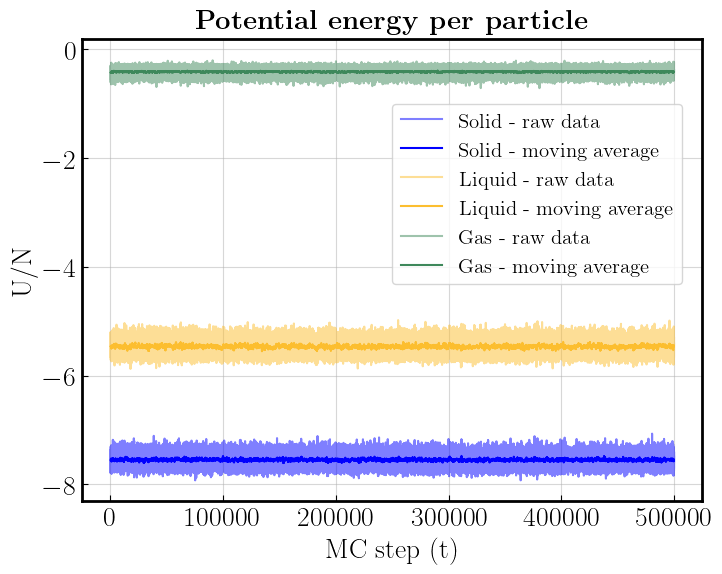

In [5]:
dim = solid.shape[0]
start = int(size/2)
end = int(dim - size/2 + 1)

plt.plot(solid[:,0], solid[:,1], c='blue', alpha=0.5, label='Solid - raw data')
plt.plot(solid[start:end,0], solid_mav, c='blue', label='Solid - moving average')
plt.plot(liquid[:,0], liquid[:,1], c='#FCBE2F', alpha=0.5, label='Liquid - raw data')
plt.plot(liquid[start:end,0], liquid_mav, c='#FCBE2F', label='Liquid - moving average')
plt.plot(gas[:,0], gas[:,1], c='#3E885B', alpha=0.5, label='Gas - raw data')
plt.plot(gas[start:end,0], gas_mav, c='#3E885B', label='Gas - moving average')

plt.xlabel('MC step (t)')
plt.ylabel('U/N')
plt.title(r'\textbf{Potential energy per particle}', pad=8)
plt.legend(fontsize=15, loc=(0.5,0.47))
plt.show()

### Autocorrelation

To implement data blocking over istantaneous measures we have to choose the correct number of blocks, i.e. the correct length that allow us to consider uncorrelated the averages on adjacent blocks. Thus we have to measure the **autocorrelation function**, that measures how much the past history of a random variable influence its present value. Given two different variables, we can define their covariance (i.e. their tendency to vary in response one to another) as:

$$ \text{cov}_{[x_i,x_j]}(t_1,t_2) \coloneqq \left\langle x_i(t_1)x_j(t_2)\right\rangle - \left\langle x_i(t_1)\right\rangle \left\langle x_j(t_2)\right\rangle \ , $$

where if the two variables are equal we obtain the variance. Then we can define the autocorrelation function as:

$$ \text{Ac}_{[x]}(\tau) \coloneqq \frac{\text{cov}_{[x,x]}\left(t, t+\tau\right)}{\text{var}_{[x]}\left(t\right)} \ , $$

where $\tau$ parameter is called time lag. If autocorrelation function is positive for a certain $\tau$, it means that the values at time-distance $\tau$ influence positively the actual ones (correlated data), and on the contrary if $\text{Ac}_{[x]}(\tau)$ is negative we have anti-correlated data. Finally, a negative value of the autocorrelation means that the data are uncorrelated. Fitting the autocorrelation function with an exponential of the form $\exp(-t/\tau)$ we can extract the characteristic time $\tau$, that gives information about the time to wait to get uncorrelated values: block length must be $L \gg \tau$.


In [6]:
def expo(t, a, b) :
    return a * np.exp(-t/b)

def powlaw(t, a, b) :
    return b * t**(-a)

In [7]:
phase = [solid[:,1], liquid[:,1], gas[:,1]]
titles = ['Solid', 'Liquid', 'Gas']

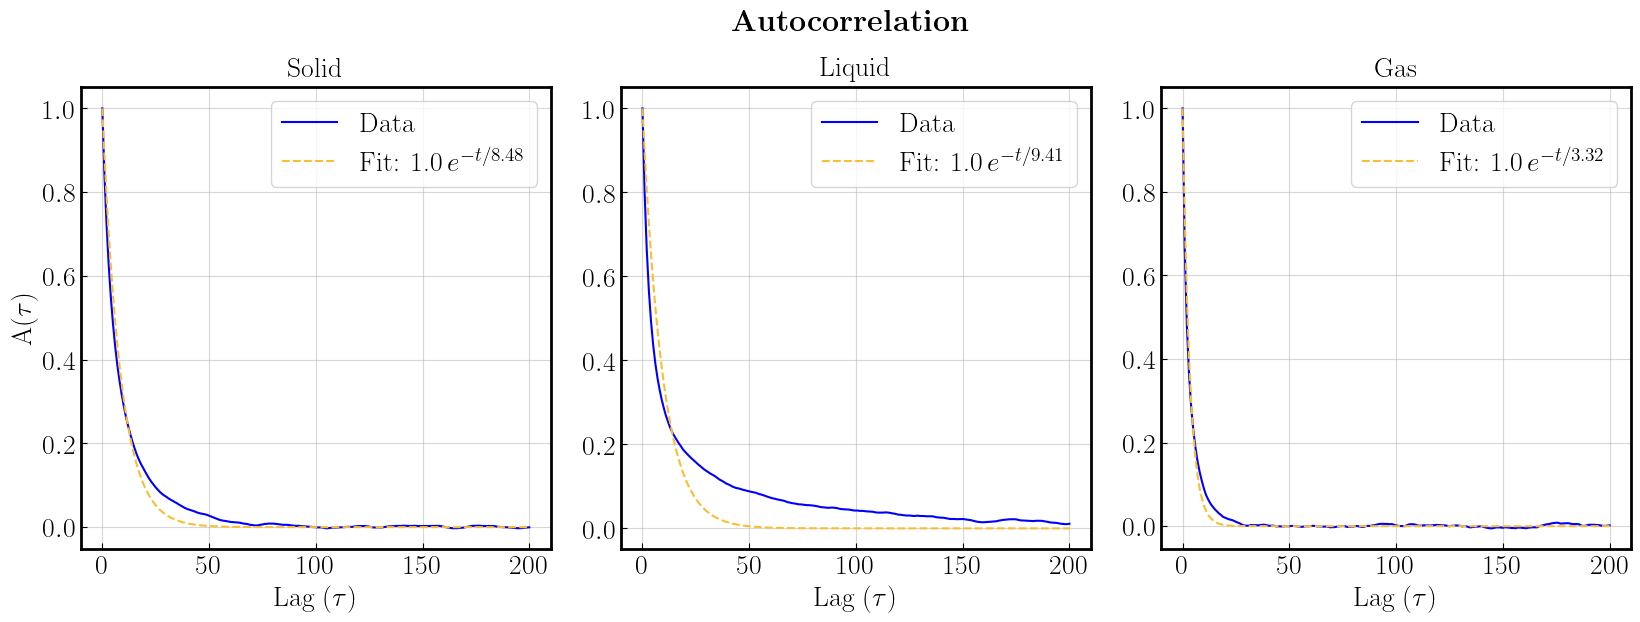

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(20,6), gridspec_kw={'wspace': 0.15})
fig.suptitle(r'\textbf{Autocorrelation}', fontsize=22, x=0.51, y=1.01)

maxlag = 200

for i in range(3) : 
    acorr = sm.tsa.acf(phase[i], nlags=maxlag)
    x = np.arange(len(acorr))
    axs[i].plot(x, acorr, c='blue', label='Data')

    # exponential fit
    popt, pcov = curve_fit(expo, x, acorr, bounds=([1, 0], [np.inf, np.inf]))
    y_expo = expo(x, *popt)
    axs[i].plot(x, y_expo, c='#FCBE2F', ls='--', label='Fit: ' + format(popt[0], '.1f') + '$ \, e^{-t/' + format(popt[1], '.2f') + '}$')

    axs[i].set_title(titles[i], pad=8)
    axs[i].set_xlabel(r'Lag ($\tau$)')
    axs[i].legend()

axs[0].set_ylabel(r'A($\tau$)')

plt.show()

The autocorrelation value decreases with time, the characteristic time $\tau$ values are:
- $\tau = 8.58$ for solid phase
- $\tau = 9.77$ for liquid phase
- $\tau = 3.27$ for gas phase

So, for all the phases, a good number of steps per block can be $1000$.

In [9]:
# blocking average function
def blocking_average(array, size) :
    nblocks = len(array) // size
    ave = 0
    ave2 = 0
    for i in range(nblocks) :
        sum = 0
        for j in range(size) :
            sum += array[i*size+j]
        sum /= size
        ave += sum
        ave2 += sum*sum
    ave /= nblocks
    ave2 /= nblocks
    return ave, np.sqrt((ave2 - ave*ave) / nblocks)

In [10]:
# computing errors in function of block length
sizes = np.arange(10, 5010, 10)
errors = np.zeros([3,len(sizes)])
for i in range(3) :
    for j in range(len(sizes)) :
        average, errors[i,j] = blocking_average(phase[i], sizes[j])

In [11]:
# moving average on errors
errors_mav = []
size = 10
for i in range(3) :
    errors_mav.append(moving_average(errors[i,:], size))
errors_mav = np.array(errors_mav)

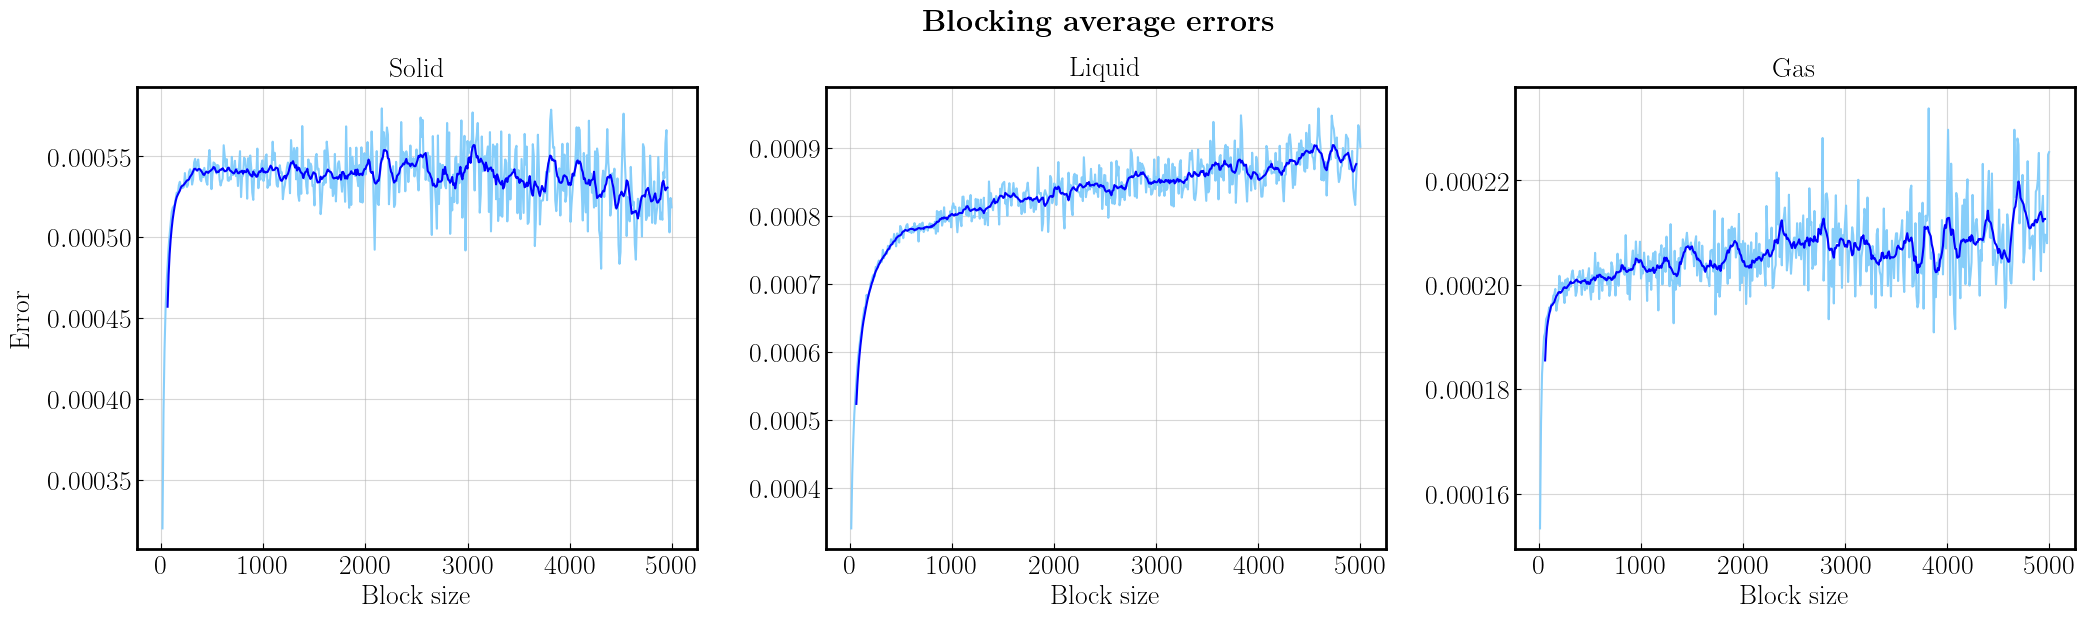

In [12]:
# plot
fig, axs = plt.subplots(1, 3, figsize=(25,6), gridspec_kw={'wspace': 0.23})
fig.suptitle(r'\textbf{Blocking average errors}', fontsize=22, x=0.51, y=1.01)

start = int(size/2)
end = int(len(sizes) - size/2 + 1)
for i in range(3) :
    axs[i].plot(sizes, errors[i,:], c='lightskyblue')
    axs[i].plot(sizes[start:end], errors_mav[i,:], c='blue')
    axs[i].set_title(titles[i], pad=8)
    axs[i].set_xlabel('Block size')

axs[0].set_ylabel('Error', labelpad=10)
plt.show()

This plots show the statistical error of the blocking average for all three phases in function of the number of step for each block (i.e. of the block length). We can see that under the threshold of $L=2000$ steps per block, the error is understimated, meaning that the values of different blocks are correlated.

# Exercise 07.3

Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the NSL simulator code: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

## Solution

The **radial distribution function** $g(r)$ measure the probability of finding two particles at distance $r$: it is a useful quantity to know because the ensemble average of any pair function can be computed by knowing it. To calculate $g(r)$ I implemented the following formula:

$$ g(r^*) = \frac{1}{\rho^* N\Delta V^*(r^*)} \left\langle \sum \sum_{i\neq j=1}^N \delta(r^*-|\vec{r_i^*} - \vec{r_j^*} |) \right\rangle $$
where $\Delta V(r^*) = \frac{4\pi}{3}\left[(r^*+dr^*)^3-(r^*)^3\right]$ is the spherical shell volume in which the particle is localized amd the $^*$ symbol denotes reduced units.

### Code
For the implementation of $g(r)$ in the simulator, divided tne interval $[0,L/2]$ into `_n_bins` bins, where `_n_bins` is given in input to the system as it rads the `INPUT/properties.dat` file. Then I filled an histogram increasing by two the counter of the bin in which a couple of particles is found, and then I divided by $\rho^* N\Delta V^*(r^*)$.

Below there is the code computing $g(r)$:
```c++
void System :: measure(){ // Measure properties
    /* ... */
    if (_measure_gofr){
        bin = int(dr/_bin_size);
        if(bin < _n_bins){
            _measurement(_index_gofr+bin) += 2.0;
        }
    }
    /* ... */
}
```

Then, the `averages()` method would print the blocking average over the bins, saving it in a file called `gofr_blocks.csv`. To this I added the creation of a new file, `gofr_final.csv`, where it is printed the final value of $g(r)$ in function of the bin, so of the distance $r$. Here I show the code:

```c++
void System :: averages(int blk, const string path){
    /* ... */
    if (_measure_gofr) {
        coutf.open(path + "OUTPUT/gofr_final.csv",ios::app);
        ofstream coutf2(path + "OUTPUT/gofr_blocks.csv",ios::app);
        double sum = 0.0, sum2 = 0.0;

        for (int i=0 ; i<_n_bins ; i++){
        sum += _average(_index_gofr + i);
        sum2 += pow(_average(_index_gofr + i), 2);

        if (blk == _nblocks){
            average = _average(_index_gofr + i);
            sum_average = _global_av(_index_gofr + i);
            sum_ave2 = _global_av2(_index_gofr + i);
            coutf << i+1
                << "," << double(i)*_bin_size
                << "," << sum_average/double(blk)
                << "," << this->error(sum_average, sum_ave2, blk) << endl;
        }
        }

        coutf2 << blk
            << "," << sum / double(_n_bins)
            << "," << this->error(sum, sum2, _n_bins) << endl;
        coutf.close();
        coutf2.close();
    }
    /* ... */
}
```

In [13]:
gofr_blocks = np.loadtxt('07.3/OUTPUT/gofr_blocks.csv', delimiter=',', skiprows=1)
gofr_final = np.loadtxt('07.3/OUTPUT/gofr_final.csv', delimiter=',', skiprows=1)

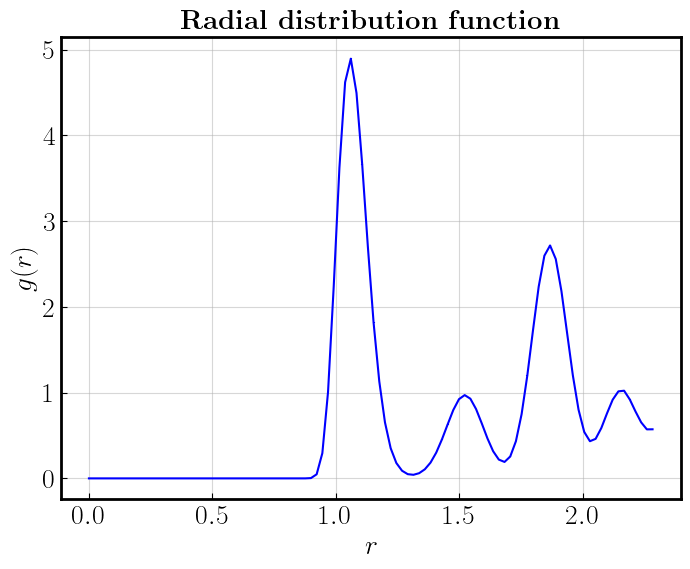

In [14]:
plt.errorbar(gofr_final[:,1], gofr_final[:,2], yerr=gofr_final[:,3], c='blue')
plt.xlabel('$r$')
plt.ylabel('$g(r)$')
plt.title(r'\textbf{Radial distribution function}')

plt.show()

Here it is represented an example of radial distribution function $g(r)$ for the solid phase.

**Plot parameters**:
- Total steps: $10^5$
- Blocks: $100$
- Steps in each block: $10^3$

# Exercise 07.4

By means of your upgraded NSL simulator code, equilibrate and perform MC NVT simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units ... and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.

## Solution

Now I compare $NVE$ simulations with $NVT$ ones, remembering that they need different kinds of equilibration.

In [15]:
epot_sol_NVE = np.loadtxt('07.4/NVE/Solid/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
epot_sol_NVT = np.loadtxt('07.4/NVT/Solid/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
epot_liq_NVE = np.loadtxt('07.4/NVE/Liquid/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
epot_liq_NVT = np.loadtxt('07.4/NVT/Liquid/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
epot_gas_NVE = np.loadtxt('07.4/NVE/Gas/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
epot_gas_NVT = np.loadtxt('07.4/NVT/Gas/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)

pres_sol_NVE = np.loadtxt('07.4/NVE/Solid/OUTPUT/pressure.csv', delimiter=',', skiprows=1)
pres_sol_NVT = np.loadtxt('07.4/NVT/Solid/OUTPUT/pressure.csv', delimiter=',', skiprows=1)
pres_liq_NVE = np.loadtxt('07.4/NVE/Liquid/OUTPUT/pressure.csv', delimiter=',', skiprows=1)
pres_liq_NVT = np.loadtxt('07.4/NVT/Liquid/OUTPUT/pressure.csv', delimiter=',', skiprows=1)
pres_gas_NVE = np.loadtxt('07.4/NVE/Gas/OUTPUT/pressure.csv', delimiter=',', skiprows=1)
pres_gas_NVT = np.loadtxt('07.4/NVT/Gas/OUTPUT/pressure.csv', delimiter=',', skiprows=1)

gofr_sol_NVE = np.loadtxt('07.4/NVE/Solid/OUTPUT/gofr_final.csv', delimiter=',', skiprows=1)
gofr_sol_NVT = np.loadtxt('07.4/NVT/Solid/OUTPUT/gofr_final.csv', delimiter=',', skiprows=1)
gofr_liq_NVE = np.loadtxt('07.4/NVE/Liquid/OUTPUT/gofr_final.csv', delimiter=',', skiprows=1)
gofr_liq_NVT = np.loadtxt('07.4/NVT/Liquid/OUTPUT/gofr_final.csv', delimiter=',', skiprows=1)
gofr_gas_NVE = np.loadtxt('07.4/NVE/Gas/OUTPUT/gofr_final.csv', delimiter=',', skiprows=1)
gofr_gas_NVT = np.loadtxt('07.4/NVT/Gas/OUTPUT/gofr_final.csv', delimiter=',', skiprows=1)

### Solid

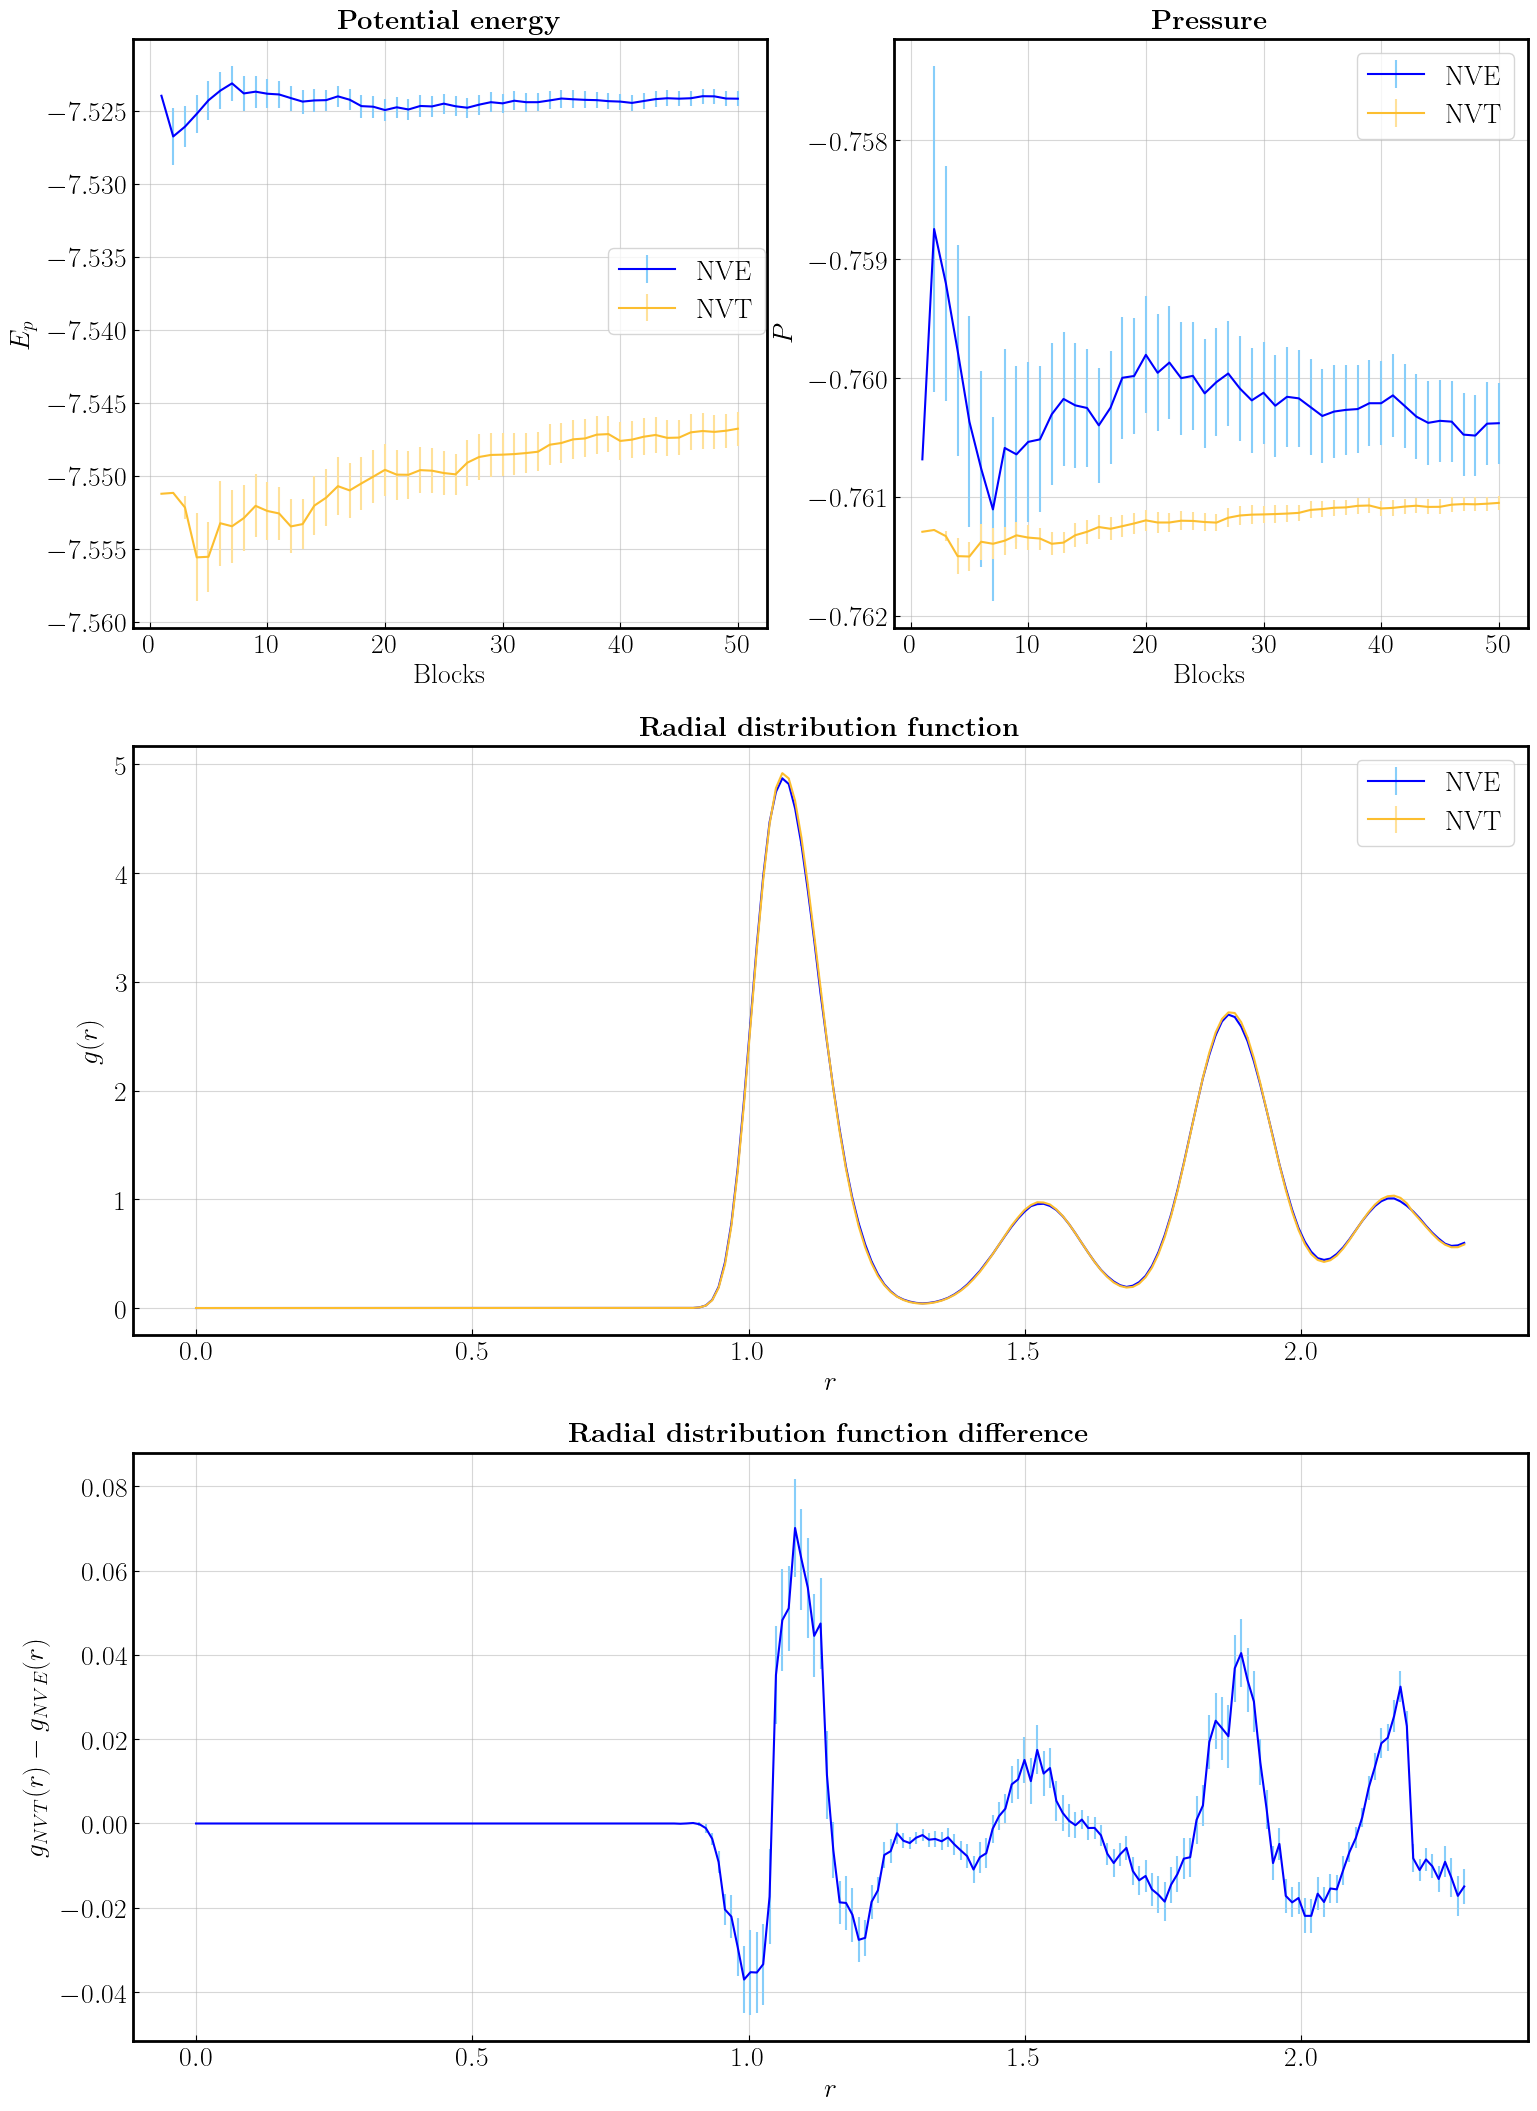

In [26]:
fig = plt.figure(figsize=(18,26))
gs = gridspec.GridSpec(3, 2)


ax1 = fig.add_subplot(gs[0, 0])
ax1.errorbar(epot_sol_NVE[:,0], epot_sol_NVE[:,2], yerr=epot_sol_NVE[:,3], c='blue', ecolor='lightskyblue', label='NVE')
ax1.errorbar(epot_sol_NVT[:,0], epot_sol_NVT[:,2], yerr=epot_sol_NVT[:,3], c='#FCBE2F', ecolor='#FFE19A', label='NVT')

ax1.set_xlabel('Blocks')
ax1.set_ylabel('$E_p$', labelpad=8)
ax1.set_title(r'\textbf{Potential energy}', pad=8)
ax1.legend(loc=(0.75,0.5))


ax2 = fig.add_subplot(gs[0, 1])
ax2.errorbar(pres_sol_NVE[:,0], pres_sol_NVE[:,2], yerr=pres_sol_NVE[:,3], c='blue', ecolor='lightskyblue', label='NVE')
ax2.errorbar(pres_sol_NVT[:,0], pres_sol_NVT[:,2], yerr=pres_sol_NVT[:,3], c='#FCBE2F', ecolor='#FFE19A', label='NVT')

ax2.set_xlabel('Blocks')
ax2.set_ylabel('$P$', labelpad=8)
ax2.set_title(r'\textbf{Pressure}', pad=8)
ax2.legend()


ax3 = fig.add_subplot(gs[1, :])
ax3.errorbar(gofr_sol_NVE[:,1], gofr_sol_NVE[:,2], yerr=gofr_sol_NVE[:,3], c='blue', ecolor='lightskyblue', label='NVE')
ax3.errorbar(gofr_sol_NVT[:,1], gofr_sol_NVT[:,2], yerr=gofr_sol_NVT[:,3], c='#FCBE2F', ecolor='#FFE19A', label='NVT')

ax3.set_xlabel('$r$')
ax3.set_ylabel('$g(r)$', labelpad=8)
ax3.set_title(r'\textbf{Radial distribution function}', pad=8)
ax3.legend()


ax4 = fig.add_subplot(gs[2, :])
ax4.errorbar(gofr_sol_NVE[:,1], gofr_sol_NVT[:,2] - gofr_sol_NVE[:,2], yerr=np.sqrt(gofr_sol_NVT[:,3]**2 + gofr_sol_NVE[:,3]**2), c='blue', ecolor='lightskyblue')

ax4.set_xlabel('$r$')
ax4.set_ylabel('$g_{NVT}(r) - g_{NVE}(r)$', labelpad=8)
ax4.set_title(r'\textbf{Radial distribution function difference}', pad=8)


plt.show()

The shape of the radial distribution function $g(r)$ for the solid phase has a plateau at zero in the spatial region where the Lennard Jones potential is repulsive, meaning that there is no probability to find a couple of particles very near one to each other. Then the function presents some peaks, meaning characteristic distances at which we can find a couple of particles, and this denotes the regular structure of the solid phase.

**Plot parameters**:
- Total steps: $10^5$
- Blocks: $50$
- Steps in each block: $2\times10^3$

### Liquid

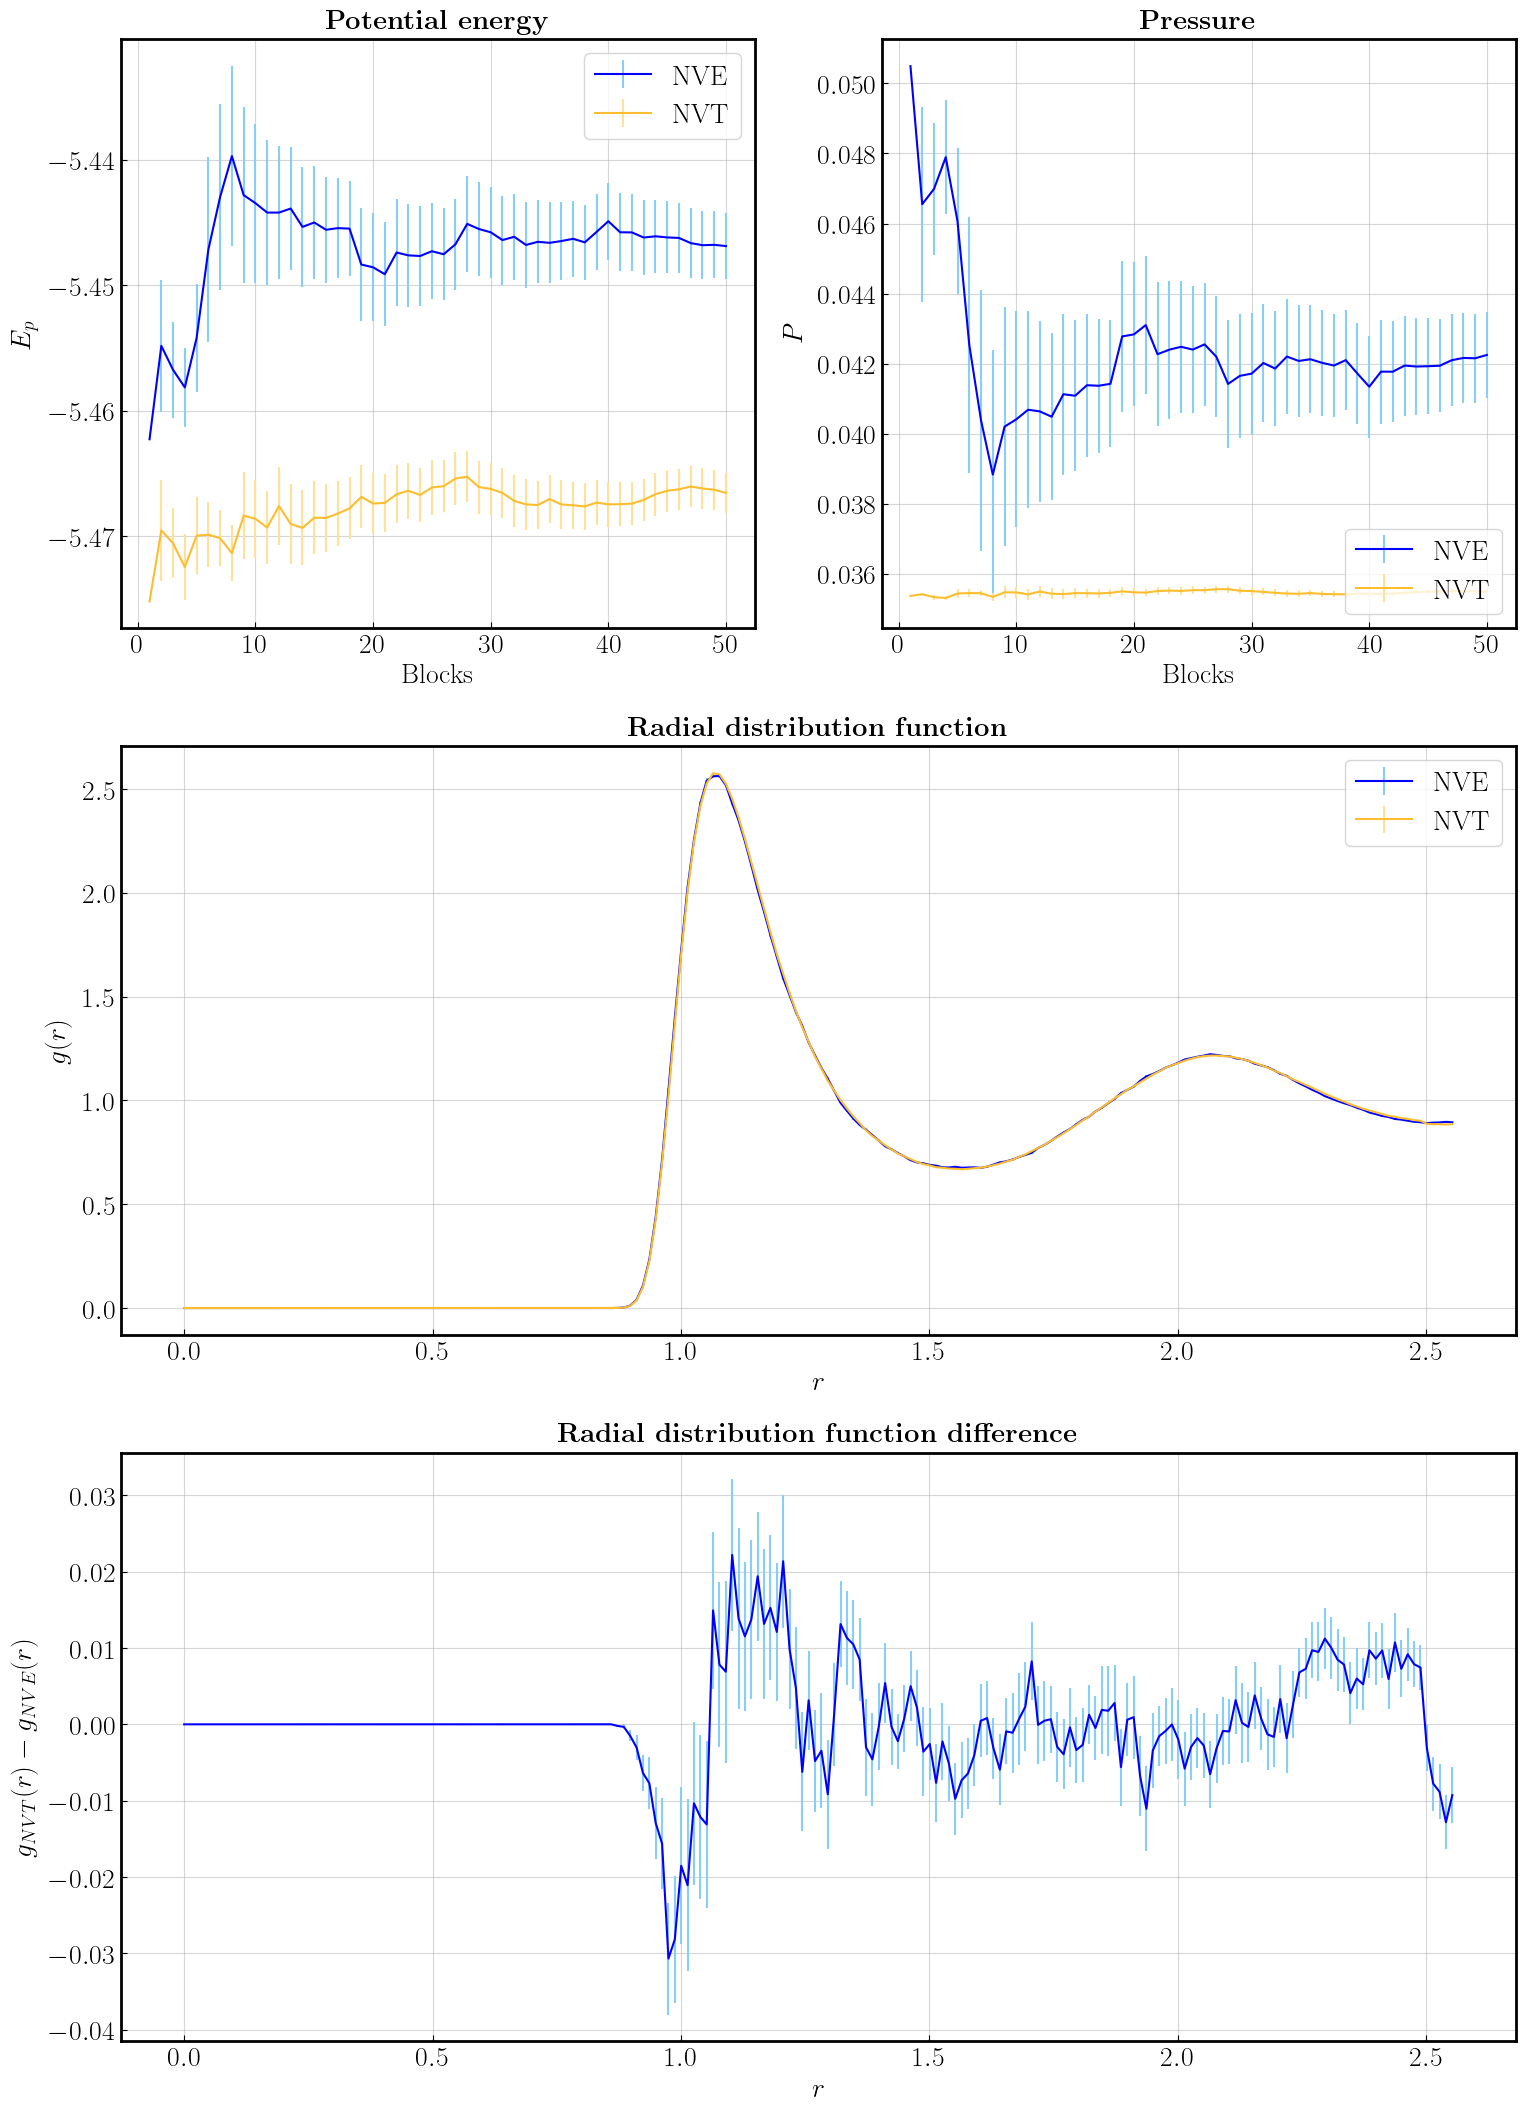

In [27]:
fig = plt.figure(figsize=(18,26))
gs = gridspec.GridSpec(3, 2)


ax1 = fig.add_subplot(gs[0, 0])
ax1.errorbar(epot_liq_NVE[:,0], epot_liq_NVE[:,2], yerr=epot_liq_NVE[:,3], c='blue', ecolor='lightskyblue', label='NVE')
ax1.errorbar(epot_liq_NVT[:,0], epot_liq_NVT[:,2], yerr=epot_liq_NVT[:,3], c='#FCBE2F', ecolor='#FFE19A', label='NVT')

ax1.set_xlabel('Blocks')
ax1.set_ylabel('$E_p$', labelpad=8)
ax1.set_title(r'\textbf{Potential energy}', pad=8)
ax1.legend()


ax2 = fig.add_subplot(gs[0, 1])
ax2.errorbar(pres_liq_NVE[:,0], pres_liq_NVE[:,2], yerr=pres_liq_NVE[:,3], c='blue', ecolor='lightskyblue', label='NVE')
ax2.errorbar(pres_liq_NVT[:,0], pres_liq_NVT[:,2], yerr=pres_liq_NVT[:,3], c='#FCBE2F', ecolor='#FFE19A', label='NVT')

ax2.set_xlabel('Blocks')
ax2.set_ylabel('$P$', labelpad=8)
ax2.set_title(r'\textbf{Pressure}', pad=8)
ax2.legend(loc='lower right')


ax3 = fig.add_subplot(gs[1, :])
ax3.errorbar(gofr_liq_NVE[:,1], gofr_liq_NVE[:,2], yerr=gofr_liq_NVE[:,3], c='blue', ecolor='lightskyblue', label='NVE')
ax3.errorbar(gofr_liq_NVT[:,1], gofr_liq_NVT[:,2], yerr=gofr_liq_NVT[:,3], c='#FCBE2F', ecolor='#FFE19A', label='NVT')

ax3.set_xlabel('$r$')
ax3.set_ylabel('$g(r)$', labelpad=8)
ax3.set_title(r'\textbf{Radial distribution function}', pad=8)
ax3.legend()

ax4 = fig.add_subplot(gs[2, :])
ax4.errorbar(gofr_liq_NVE[:,1], gofr_liq_NVT[:,2] - gofr_liq_NVE[:,2], yerr=np.sqrt(gofr_liq_NVT[:,3]**2 + gofr_liq_NVE[:,3]**2), c='blue', ecolor='lightskyblue')

ax4.set_xlabel('$r$')
ax4.set_ylabel('$g_{NVT}(r) - g_{NVE}(r)$', labelpad=8)
ax4.set_title(r'\textbf{Radial distribution function difference}', pad=8)


plt.show()

Like in the solid case, also for the liquid phase the particles can't be too close to each other, in fact $g(r)$ presents the same flat region with probability near to zero at small distances. There are also a few peaks, less defined, meaning that the structure of the system is less regular than the solid phase.

**Plot parameters**:
- Total steps: $10^5$
- Blocks: $50$
- Steps in each block: $2\times10^3$

### Gas

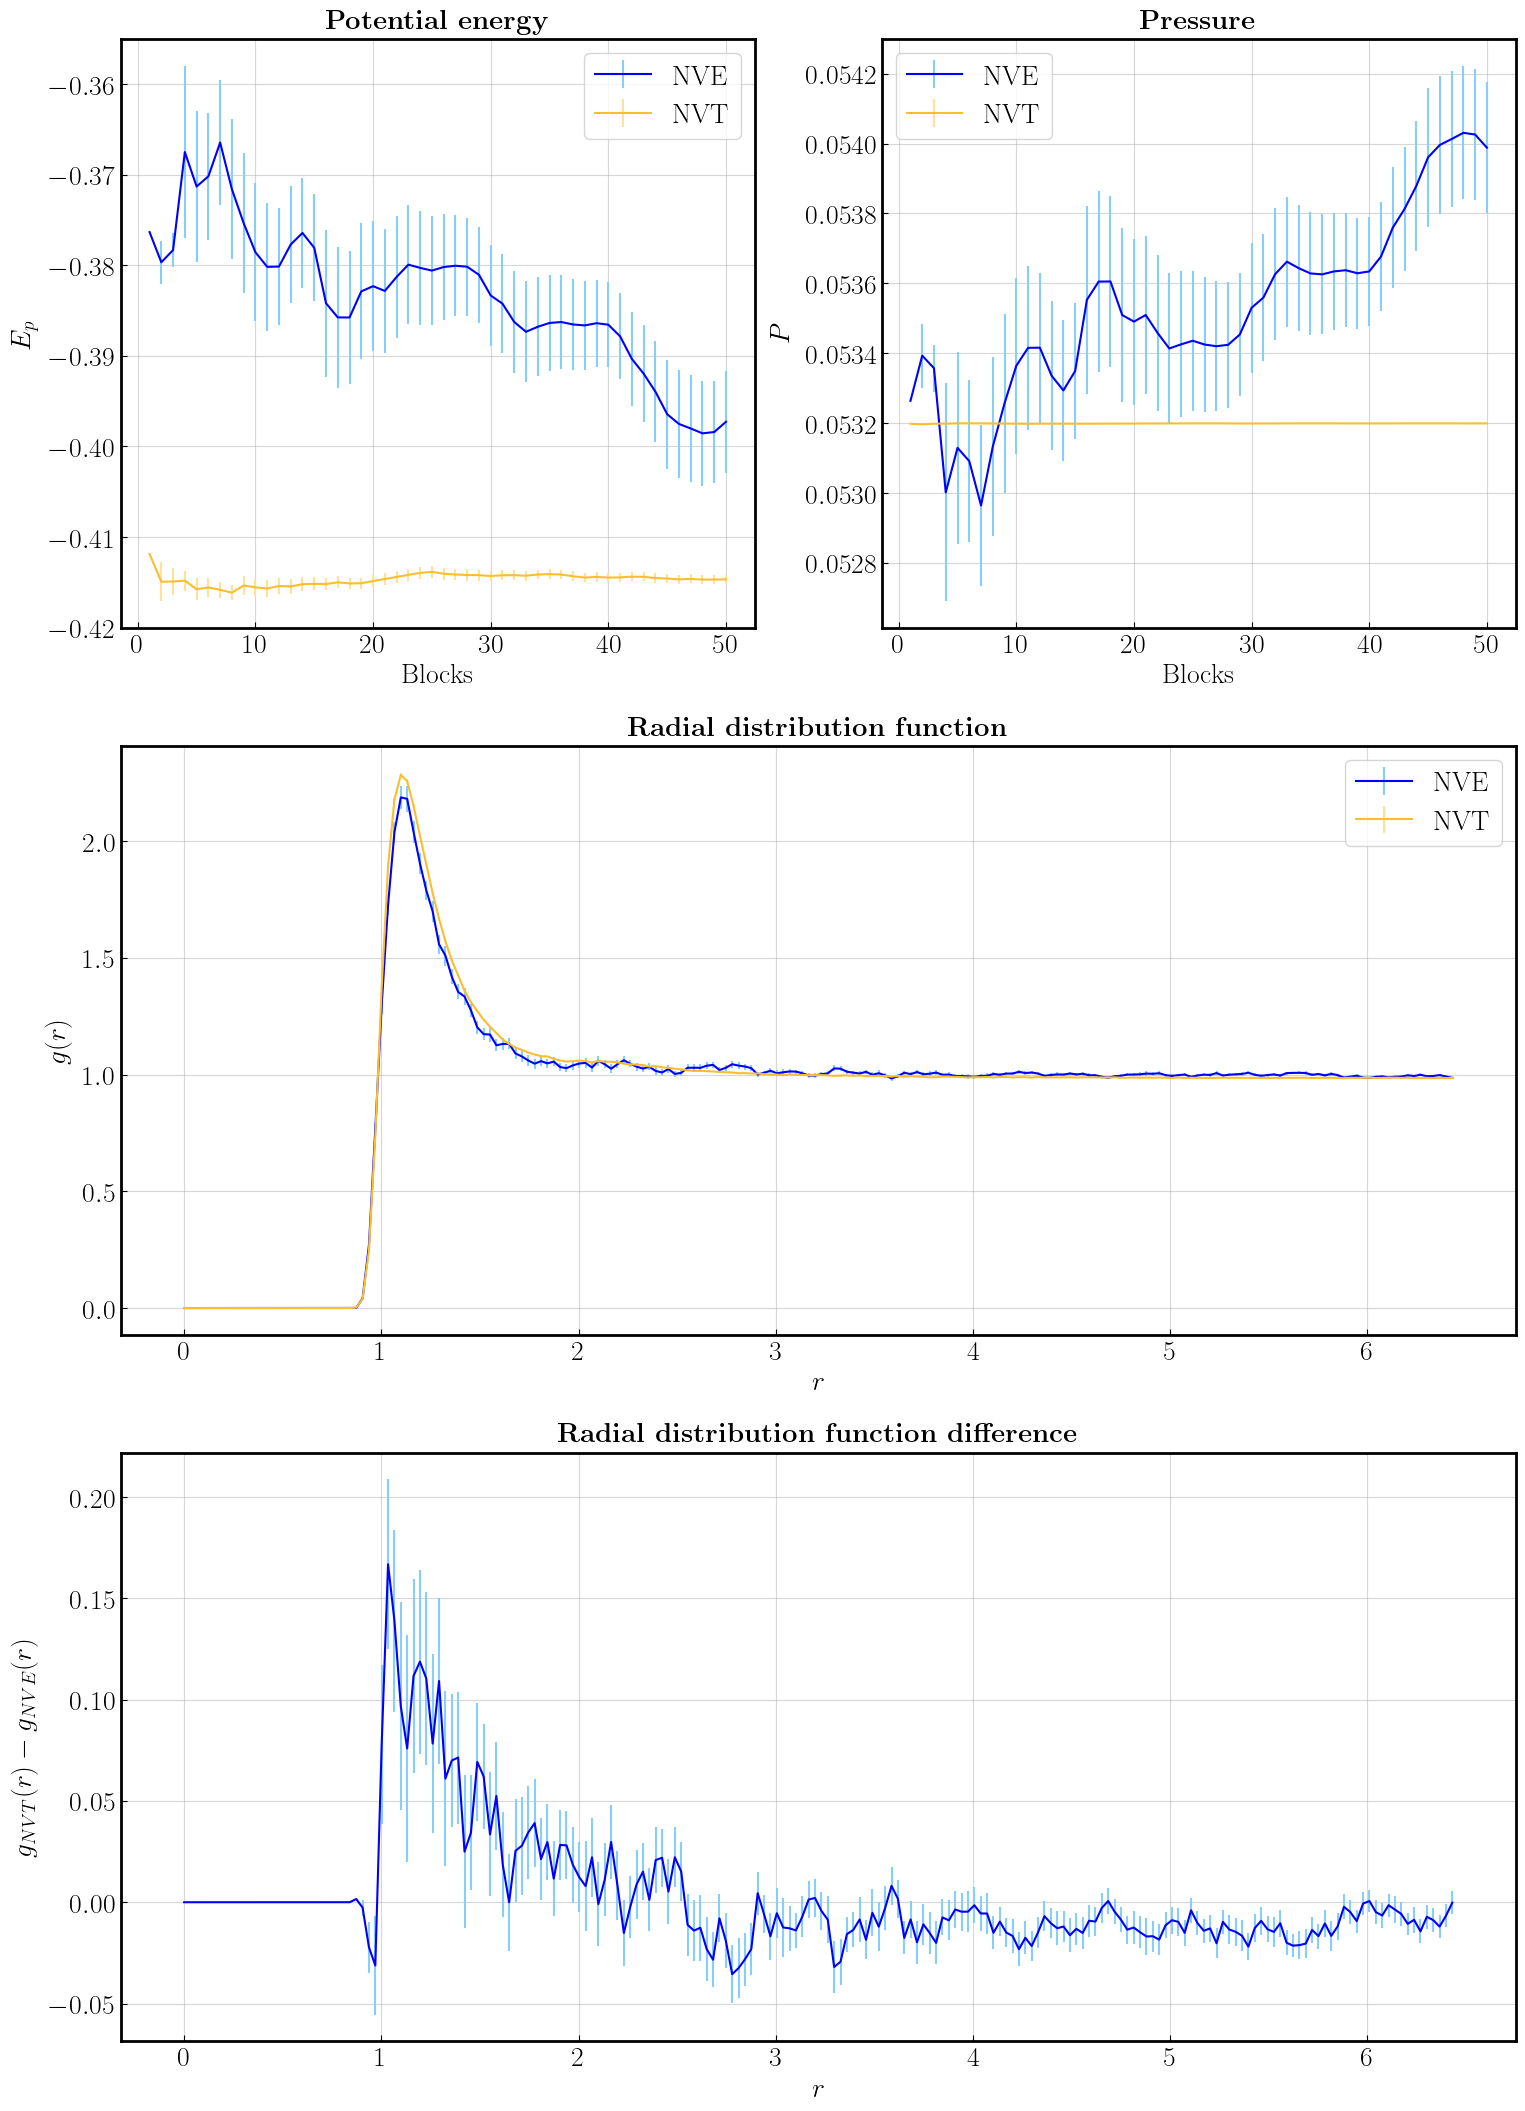

In [29]:
fig = plt.figure(figsize=(18,26))
gs = gridspec.GridSpec(3, 2)


ax1 = fig.add_subplot(gs[0, 0])
ax1.errorbar(epot_gas_NVE[:,0], epot_gas_NVE[:,2], yerr=epot_gas_NVE[:,3], c='blue', ecolor='lightskyblue', label='NVE')
ax1.errorbar(epot_gas_NVT[:,0], epot_gas_NVT[:,2], yerr=epot_gas_NVT[:,3], c='#FCBE2F', ecolor='#FFE19A', label='NVT')

ax1.set_xlabel('Blocks')
ax1.set_ylabel('$E_p$', labelpad=8)
ax1.set_title(r'\textbf{Potential energy}', pad=8)
ax1.legend()


ax2 = fig.add_subplot(gs[0, 1])
ax2.errorbar(pres_gas_NVE[:,0], pres_gas_NVE[:,2], yerr=pres_gas_NVE[:,3], c='blue', ecolor='lightskyblue', label='NVE')
ax2.errorbar(pres_gas_NVT[:,0], pres_gas_NVT[:,2], yerr=pres_gas_NVT[:,3], c='#FCBE2F', ecolor='#FFE19A', label='NVT')

ax2.set_xlabel('Blocks')
ax2.set_ylabel('$P$', labelpad=8)
ax2.set_title(r'\textbf{Pressure}', pad=8)
ax2.legend()


ax3 = fig.add_subplot(gs[1, :])
ax3.errorbar(gofr_gas_NVE[:,1], gofr_gas_NVE[:,2], yerr=gofr_gas_NVE[:,3], c='blue', ecolor='lightskyblue', label='NVE')
ax3.errorbar(gofr_gas_NVT[:,1], gofr_gas_NVT[:,2], yerr=gofr_gas_NVT[:,3], c='#FCBE2F', ecolor='#FFE19A', label='NVT')

ax3.set_xlabel('$r$')
ax3.set_ylabel('$g(r)$', labelpad=8)
ax3.set_title(r'\textbf{Radial distribution function}', pad=8)
ax3.legend()

ax4 = fig.add_subplot(gs[2, :])
ax4.errorbar(gofr_gas_NVE[:,1], gofr_gas_NVT[:,2] - gofr_gas_NVE[:,2], yerr=np.sqrt(gofr_gas_NVT[:,3]**2 + gofr_gas_NVE[:,3]**2), c='blue', ecolor='lightskyblue')

ax4.set_xlabel('$r$')
ax4.set_ylabel('$g_{NVT}(r) - g_{NVE}(r)$', labelpad=8)
ax4.set_title(r'\textbf{Radial distribution function difference}', pad=8)


plt.show()

In the case of the gas phase, there is always the initial plateau at small distances, then the radial distribution function grows to a global maximum corresponding to the minimum of Lennard Jones potential. Anyway there are no peaks nor any other sign of a regular structure, meaning that the gas phase is mainly disordered.

**Plot parameters**:
- Total steps: $10^5$
- Blocks: $50$
- Steps in each block: $2\times10^3$

## Observations
Comparing the radial distribution functions in the $NVE$ and $NVT$ simulations for all three phases, we can assert that they are compatible, meaning that the code works well and the simulations reflect the spatial distribution of a real system.